In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os, sys
path = "/content/drive/MyDrive/HW5/1_VAE/5_1_2_implementation/binarized_mnist/"
sys.path.append(path)
os.makedirs(path + "/checkpoint/",exist_ok = True)

In [3]:
import time
import torch
import torch.utils.data as data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from torchvision.utils import make_grid
from collections import OrderedDict
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pdb

from helper.visualize_mnist import *
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
cuda

True

In [4]:
from encoder import Encoder 
from decoder import Decoder 

In [5]:
SEED = 1
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)
# changed configuration to this instead of argparse for easier interaction
SEED = 1

In [6]:
# load training and test files
train_data   = np.load(path+'/data/train_data_bmnist.npy')
test_data    = np.load(path+'data/test_data_bmnist.npy')

train_labels = np.load(path+'/data/train_labels_bmnist.npy')
test_labels = np.load(path+'/data/test_labels_bmnist.npy')

In [7]:
class myDataset(Dataset):
  def __init__(self,data,labels):
    self.data = np.round(data/255.)
    self.labels = labels

  def __getitem__(self,index):
    return torch.FloatTensor(self.data[index]).unsqueeze(0),torch.tensor(self.labels[index]).unsqueeze(0)

  def __len__(self):
    return len(self.data)

In [8]:
batch_size= 128

In [9]:
train_set = myDataset(train_data,train_labels)
test_set = myDataset(test_data,test_labels)

In [10]:
train_loader = torch.utils.data.DataLoader(train_set,batch_size =batch_size, shuffle=True,drop_last=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size =batch_size, shuffle=False,drop_last=True)

In [11]:
class VAE(nn.Module):
  def __init__(self,zdim):
    super(VAE,self).__init__()
    self.encoder = Encoder(zdim)
    self.decoder = Decoder(zdim)
  
  def sample(self,mu,logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu)
  

  def forward(self,x):
    mu,logvar = self.encoder(x)
    z 		  = self.sample(mu,logvar)
    return self.decoder(z), mu, logvar

In [12]:
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.kaiming_normal_(m.weight)
    nn.init.constant_(m.bias, 0.0)

In [13]:
# build model
zdim = 10
vae = VAE(zdim)
vae.apply(init_weights)
vae.to(device)
lr = 0.0001
optimizer = optim.Adam(vae.parameters(),lr=lr)


In [14]:
vae

VAE(
  (encoder): Encoder(
    (net): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): ELU(alpha=1.0, inplace=True)
      (5): Dropout(p=0.25, inplace=False)
      (6): Linear(in_features=256, out_features=128, bias=True)
      (7): ELU(alpha=1.0, inplace=True)
    )
    (mu): Linear(in_features=128, out_features=10, bias=True)
    (logvar): Linear(in_features=128, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (net): Sequential(
      (0): Linear(in_features=10, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ELU(alpha=1.0, inplace=True)
      (4): Linear(in_features=256, out_features=784, bias=True)
      (5): Tanh()
    )
  )
)

In [15]:

# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy_with_logits(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (BCE + KLD)/batch_size

In [16]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        loss.backward()
        train_loss += loss
        optimizer.step()
        if (batch_idx+1) % 150 == 0:
            print('batch_idx : {} \tLoss: {:.6f}'.format(batch_idx+1,  loss.item() / len(data)))

        del data
        torch.cuda.empty_cache()

    print('-----> Epoch : {}, Average Train Loss: {:.5f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [17]:

def test(epoch):
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            test_loss += loss_function(recon, data, mu, log_var).item()
        del data
        torch.cuda.empty_cache()

    test_loss /= len(test_loader.dataset)
    print('-----> Epoch : {}, Average Test Loss: {:.5f}'.format(epoch, test_loss))

In [18]:
for epoch in range(1, 60):
    #----------------
    #  Training 
    # ---------------
    train(epoch)

    # ------------
    #  Testing 
    # ------------
    test(epoch)
    

batch_idx : 150 	Loss: 2.822515
batch_idx : 300 	Loss: 2.695812
-----> Epoch : 1, Average Train Loss: 2.99390
-----> Epoch : 1, Average Test Loss: 2.64051
batch_idx : 150 	Loss: 2.604993
batch_idx : 300 	Loss: 2.576877
-----> Epoch : 2, Average Train Loss: 2.61719
-----> Epoch : 2, Average Test Loss: 2.54935
batch_idx : 150 	Loss: 2.539006
batch_idx : 300 	Loss: 2.541709
-----> Epoch : 3, Average Train Loss: 2.54890
-----> Epoch : 3, Average Test Loss: 2.49975
batch_idx : 150 	Loss: 2.536205
batch_idx : 300 	Loss: 2.521108
-----> Epoch : 4, Average Train Loss: 2.51052
-----> Epoch : 4, Average Test Loss: 2.46829
batch_idx : 150 	Loss: 2.485016
batch_idx : 300 	Loss: 2.502821
-----> Epoch : 5, Average Train Loss: 2.48575
-----> Epoch : 5, Average Test Loss: 2.45010
batch_idx : 150 	Loss: 2.479931
batch_idx : 300 	Loss: 2.454054
-----> Epoch : 6, Average Train Loss: 2.46604
-----> Epoch : 6, Average Test Loss: 2.43120
batch_idx : 150 	Loss: 2.466547
batch_idx : 300 	Loss: 2.455561
----->

In [19]:
PATH = path+'/checkpoint/encoder.pt'
torch.save(vae.encoder.state_dict(), PATH)

PATH = path+'/checkpoint/decoder.pt'
torch.save(vae.decoder.state_dict(), PATH)

In [20]:
# testing 
model= VAE(zdim)
PATH = path + '/checkpoint/encoder.pt'
model.encoder.load_state_dict(torch.load(PATH))
PATH = path + '/checkpoint/decoder.pt'
model.decoder.load_state_dict(torch.load(PATH))
model.to(device)

VAE(
  (encoder): Encoder(
    (net): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Dropout(p=0.25, inplace=False)
      (3): Linear(in_features=256, out_features=256, bias=True)
      (4): ELU(alpha=1.0, inplace=True)
      (5): Dropout(p=0.25, inplace=False)
      (6): Linear(in_features=256, out_features=128, bias=True)
      (7): ELU(alpha=1.0, inplace=True)
    )
    (mu): Linear(in_features=128, out_features=10, bias=True)
    (logvar): Linear(in_features=128, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (net): Sequential(
      (0): Linear(in_features=10, out_features=256, bias=True)
      (1): ELU(alpha=1.0, inplace=True)
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): ELU(alpha=1.0, inplace=True)
      (4): Linear(in_features=256, out_features=784, bias=True)
      (5): Tanh()
    )
  )
)

In [21]:
z = torch.randn(12, zdim).cuda()
sample = model.decoder(z).cpu().detach()

In [22]:
def imshow(img):
    img = img.numpy()  # 1, 28, 28
    print(img.shape)
    plt.imshow(img.transpose((1,2,0)).squeeze(2), cmap='gray')  # 28, 28
    plt.show()

(1, 28, 28)


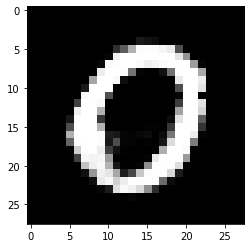

In [23]:
imshow(sample[6].reshape(1,28,28))